In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import scipy.linalg as sla
from CA_4_support import *

from matplotlib import animation,rc
from IPython.display import HTML

<div class="alert alert-info">

<h1>Motivation: Cooling of a rod given an initial temperature </h1>

<img src="heat_transfer.png" width=500>

The time-dependent diffusion equation is a partial differential equation (PDE) that is often used to model heat transfer problems:
    
$$\frac{\partial u}{\partial t} - D\frac{\partial^2 u}{\partial x^2} = 0$$
    
where $u$ is the temperature that varies in space $x$ and time $t$, i.e., $u(x,t)$. $D$ is the thermal diffusivity (in the example below assumed as 0.1).
    
</div>

# Time-Dependent Diffusion Equation

We will solve the PDE:

$$\frac{\partial u}{\partial t} - D\frac{\partial^2 u}{\partial x^2} = 0$$

In our example, a rod is placed between two insulated walls, and the space dimension is defined as $x \in [-1,1]$. As such the boundary conditions become

$$u(-1,t) = 0$$ 
$$ u(1,t) = 0$$

for $t>0$, which states that after the initial condition, the temperature at the walls is fixed and equal to zero. The initial condition (the temperature at the initial time $t = 0$) is given as:


$$u(x,0) = u_0 = 0.5 \textrm{   for any    } x \in [-1,1]$$


Using physical intuition, you may see that the temperature $u \rightarrow 0$ as $t \rightarrow \infty$.


To find the solution $u(x,t)$ we will use the same time-stepping scheme of the same form:

\begin{align}
\mathbf{A}\mathbf{u}^{(1)} &= \mathbf{b}^{(0)}\\
\mathbf{A}\mathbf{u}^{(2)} &= \mathbf{b}^{(1)}\\
\mathbf{A}\mathbf{u}^{(3)} &= \mathbf{b}^{(2)}\\
&\ \vdots\\
\mathbf{A}\mathbf{u}^{(n+1)} &= \mathbf{b}^{(n)}
\end{align}

**Using SEM, we provide:**

```python
A,x =  SEM_system_3(N, dt)
```

that takes $N$ the number of intervals in space and the time interval $dt$, and returns the points $x_i$ in the interval $([-1,1]$ and the system matrix $\mathbf{A}$. The return 1d numpy array `x` has shape `(N+1,)`, since it includes the end points. The system matrix `A` is stored as a 2d numpy array with shape `(N-1,N-1)` (since the temperature at the two end points are known and equal to zero).


**We also provide:**

```python
bn = SEM_rhs_3(un)
```
to get the right-hand side $\mathbf{b}^{(n)}$, which is a vector that depends on the temperature $\mathbf{u}^{(n)}$ (at the same timestep). The input argument `un` is a 1d numpy array with shape `(N+1)` including the boundary conditions. The return value `bn` is a 1d numpy array with shape `(N-1,)`, since it excludes the known temperatures at the walls.

**And we assume:**

In [2]:
dt = 0.05            # time increment
timesteps = 400      # number of timesteps
u0 = 0.5             # initial temperature in the rod
N = 100

**Try this!**  

Define the system matrix ${\bf A}$ and the array with the discretized points ${\bf x}$ :

In [3]:
#clear
A,x = SEM_system_3(N,dt)

In [4]:
A.shape

(99, 99)

The diffusion equation leads to a *symmetric positive-definite* matrix.  This means that $\mathbf{A} = \mathbf{A}^T$ and the eigenvalues of $\mathbf{A}$ are positive (your will learn about eigenvalues this week). Let's check!

In [5]:
# check for symmetry
print(np.allclose(A,A.T))

# check that smallest eigenvalue is positive
eig_vals = np.linalg.eigvals(A)
print(np.min(eig_vals) > 0)

True
True


Instead of an LU factorization, we'll use the Cholesky factorization: $\mathbf{A} = \mathbf{U}^T\mathbf{U}$, where $\mathbf{U}$ is an upper triangular matrix. 

[https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.cholesky.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.cholesky.html)

This is a more efficient factorization method for symmetric positive-definite matrices) - about half the number of floating operations of LU factorization.

Let's compare the computational time for both methods:

In [6]:
%timeit sla.cholesky(A)

88.4 µs ± 17.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
%timeit sla.lu(A)

142 µs ± 3.52 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


**Check your answers:** 

We will store all the vectors $\mathbf{u}^{(0)}$, $\mathbf{u}^{(1)}$, $\mathbf{u}^{(2)}$,$\dots$ as columns of a 2d numpy array `utotal` with the appropriate shape.

```python
utotal = np.zeros((N+1,timesteps+1))
```

Write the function `solve_diffusion` that returns the solution stored in `utotal`. Your function must call `sla.cholesky` and `sla.solve_triangular` to evolve the solution forward. 

In [8]:
#grade_clear
#clear
def solve_diffusion(A,u0,N,timesteps):
    # A: system matrix as 2d numpy array
    # u0: initial temperature (scalar)
    # N: number of intervals in space (along the rod)
    # timestep: number of timesteps
    
    # write code here
    
    utotal = np.zeros((N+1,timesteps+1))
    
    #clear    
    U = sla.cholesky(A)   
    ut0 = u0*np.ones(N+1)
    utotal[:,0] = ut0

    for i in range(timesteps):
        u_old = utotal[:,i]
        b = SEM_rhs_3(u_old)
        b1 = sla.solve_triangular(U.T,b,lower=True,unit_diagonal=False)
        u_new = sla.solve_triangular(U,b1,lower=False,unit_diagonal=False)
        utotal[:,i+1] = np.append(0,np.append(u_new,0))
    
    #clear
    return utotal

In [9]:
utotal = solve_diffusion(A,u0,N,timesteps)

Another movie..

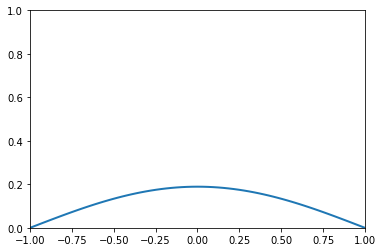

In [10]:
fig,ax = plt.subplots()
ax.set_xlim((-1,1))
ax.set_ylim((0,1.0))
line, = ax.plot([],[],lw=2)

def init():
    line.set_data([],[])
    return (line,)

def animate(i):
    y = utotal[:,i]
    line.set_data(x,y)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=50, blit=True)

rc('animation',html='html5')
anim

(0, 1)

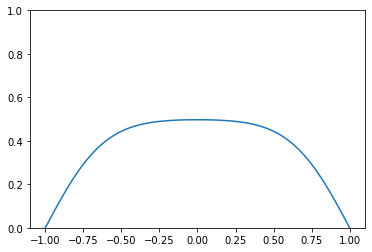

In [11]:
plt.plot(x,utotal[:,10])
plt.ylim(0,1)